# Tutorial - Sheet Model Usage

This notebook demonstrates how to quickly do a simulation using either the synchronous or asynchronous algorithm sheet model algorithms.

There are additional options (especially concerning the algorithms output format) which are not covered. For the majority of the scenarios, there is no problem keeping these parameters to their default values. Nonetheless, if you are interested feel free to read the documentation SyncSheetModel(), AsyncSheetModel(), and the extra ModSyncSheetModel()

For details regarding the implementation of the algorithms feel free to check Appendix A from [Do Graph Neural Networks Dream of Landau Damping? Insights from Kinetic Simulations of a Plasma Sheet Model](https://arxiv.org/abs/2310.17646) and Code Snippets + illustrations present in a [companion notebook](Sheet_Model_Illustration.ipynb).

In [1]:
import os
import sys
import glob
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sys.path.append('../..')
from sheet_model.synchronous import SyncSheetModel
from sheet_model.asynchronous import AsyncSheetModel
from sheet_model.utils import get_dx_eq, get_x_eq, get_E, async2sync, plot_XVE

Independently of the algorithm chosen, one must define the system size, and boundary conditions

In [2]:
n_sheets = 10 # number of sheets
L =  1 # box size [arb. units]
boundary = 'periodic' # 'periodic' or 'reflecting'

These, immediately define what are the equilibrium positions ($x_{eq}$) and intersheet distance in equilibrium ($\delta$, below written as dx_eq).

It is not necessary to initialize these two variables, but they can be usefull for plotting, normalizing units, define initial conditions, etc.

In [3]:
x_eq = get_x_eq(n_sheets, L)
dx_eq = get_dx_eq(n_sheets, L)
print('x_eq:', x_eq)
print('dx_eq:', dx_eq)

x_eq: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
dx_eq: 0.1


We must then define the initial position and velocities of the sheets. 

For simplicity, we will initialize the sheets in their equilibrium positions, with random velocities sampled from a uniform distribution

In [4]:
np.random.seed(42) # for reproducibility

x_0 = x_eq.copy()

v_max = 2 * dx_eq # max initial velocity [L w_p]
v_0 = np.random.uniform(-v_max,v_max, n_sheets)

## Synchronous Simulation

To perform a synchronous simulation, one needs to define a few extra parameters. Depending on the chosen initial conditions, some of these parameters will impact significantly the run-time/energy conservation capabilities of the algorithm.

The ones which impact the most the algorithm performance are:

- dt :
    simulation time step [1 / $\omega_p$], dt = $2\pi$ corresponds to an oscillation period. 

- n_it_crossings : number of iterations used to estimate sheet crossing times.

Choosing larger time steps will not lead to proportional decreases in run-time, since more crossings have to be resolved at each iteration. Furthermore, the relative energy variation of the algorithm is approximately $\propto  \Delta t^4$. For this reason, for larger initial velocities, one should use smaller values of dt.

Setting n_it_crossings = 2 guarantees the best energy conservation capabilities with minimum increases in run-time. We recommend setting this as the default value.

In [5]:
dt = 1e-2
n_it_crossings = 2

Two other parameters must be set which do not directly impact performance but guarantee the correct functioning of the algorithm + chage the output trajectories format. They are:

- n_guards : number of guard sheets. 

- track_sheets: if True, trajectories are returned as if sheets crossed each other. Otherwise, trajectories will represent crossings as collisions.

For larger values of dt and/or sheet velocities, one needs to increase the number of guards accordingly to ensure no sheet crosses all guards in any time-step. The simulation will halt (and return an error) if this condition is violated.

In [6]:
n_guards = 2
track_sheets = True

One can then initialize the simulator

In [7]:
sim = SyncSheetModel(L=L,
                     boundary=boundary,
                     n_sheets=n_sheets,
                     dt=dt,
                     n_it_crossings=n_it_crossings,
                     n_guards=n_guards,
                     track_sheets=track_sheets)

And run a simulation

In [8]:
t_max = 10 # simulation time [1/w_p]

X, V, X_eq, E = sim.run_simulation(x_0=x_0,
                                   v_0=v_0,
                                   t_max=t_max)

  0%|          | 0/1000 [00:00<?, ?it/s]

The outputs correspond to time-series of the sheets positions, velocities, equilibrium positions, and total energy of the system

In [9]:
print(X.shape, V.shape, X_eq.shape, E.shape)

(1001, 10) (1001, 10) (1001, 10) (1001,)


One can quickly plot the output trajectories ($x$) + velocities ($v$) + relative energy variation ($\Delta\varepsilon/\varepsilon_0$).

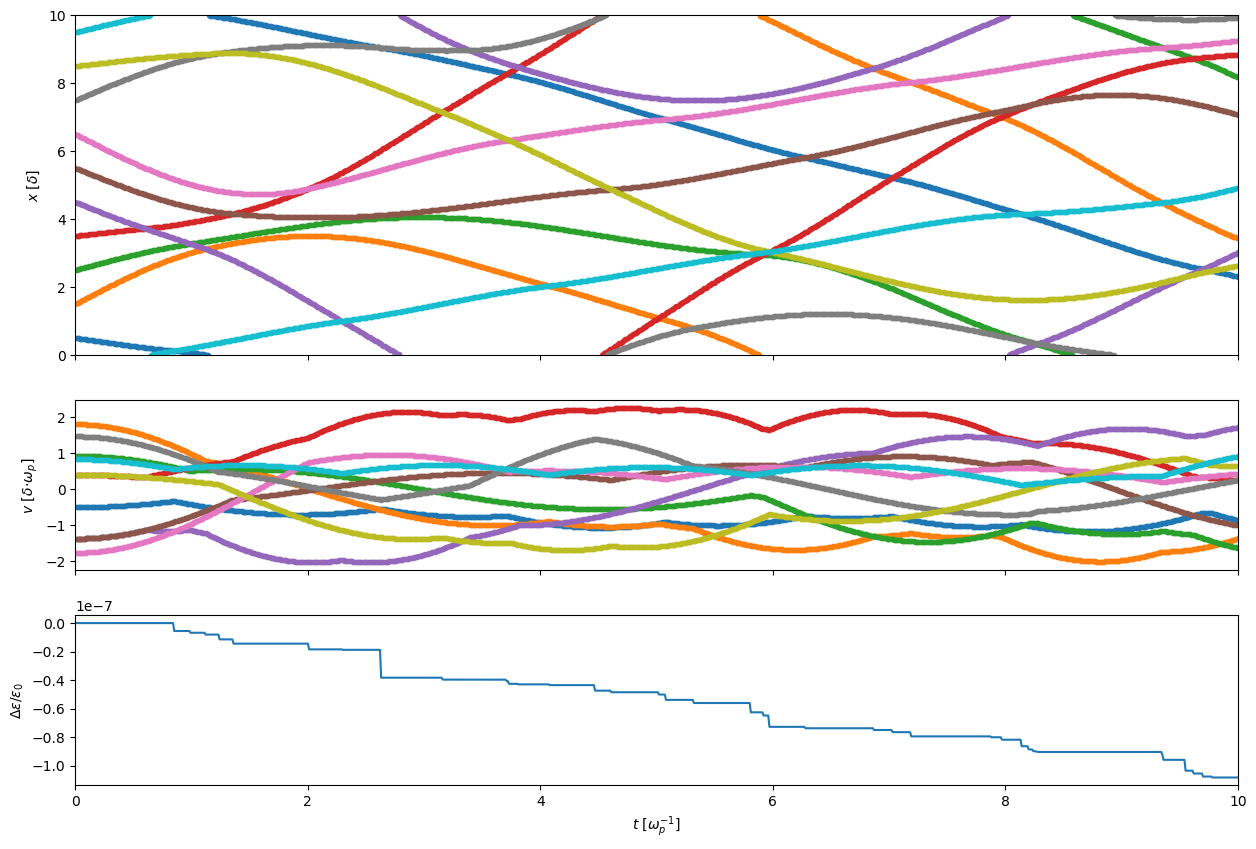

In [10]:
plot_XVE(X=X,V=V,E=E,T=dt)

**Things to try out** 
- Change the values of dt and n_it_crossings to see how it affects the energy conservation of the algorithm
- What happens when setting track_sheets=False
- Check other optional arguments in SyncSheetModel() and run_simulation()

## Asynchronous Simulation

The asynchronous algorithm advances the whole system from one crossing to the next predicted one. This means that the algorithm output is the exact solution to the motion of the sheets (up to numerical precision). 

It has a similar interface as the synchronous algorithm, although with a significantly reduced number of arguments since we do not have to select a simulation time step, and the number of guards is hard coded.

In [11]:
asim = AsyncSheetModel(L=L,
                       boundary=boundary,
                       track_sheets=track_sheets)

In [12]:
T_a, X_a, V_a, X_eq_a, E_a = asim.run_simulation(x_0=x_0,
                                                 v_0=v_0,
                                                 t_max=t_max)

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
print(T_a.shape, X_a.shape, V_a.shape, X_eq_a.shape, E_a.shape)

(43,) (43, 10) (43, 10) (43, 10) (43,)


The main difference is that now the output arrays do not represent equally spaced points in time. Instead, they represent the system state at the "precise" time a crossing occurred. This is the reason why an extra array (T_a) is returned. This new array contains the corresponding crossing times.

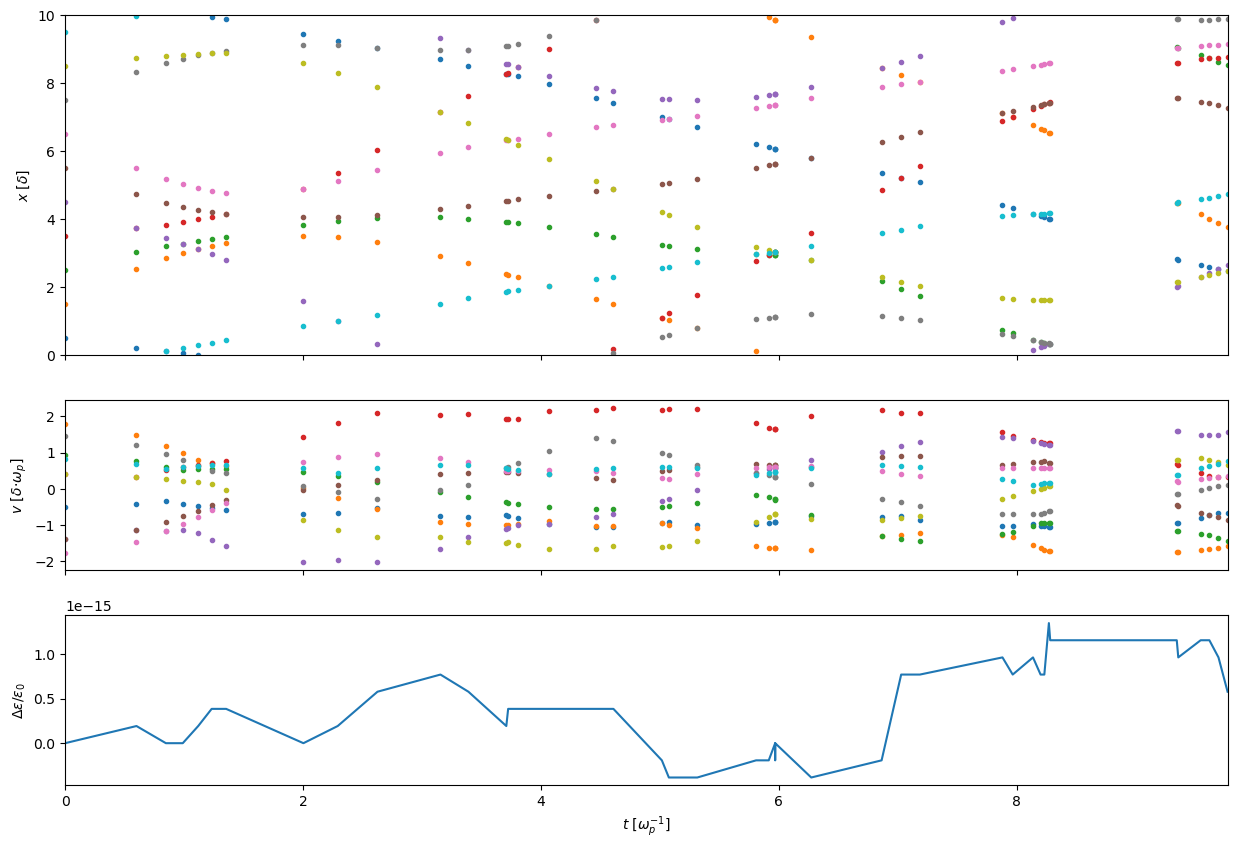

In [14]:
plot_XVE(X=X_a,V=V_a,E=E_a,T=T_a)

**Things to try out** 
- Check other optional arguments in AsyncSheetModel() and run_simulation()

## Comparing the two algorithms

We can superpose the two simulations and clearly see that:

- They are in good agreement
- The asynchronous algorithm conserves energy much better than the synchronous version (energy variation in the asynchronous model is merely a numerical artifact).

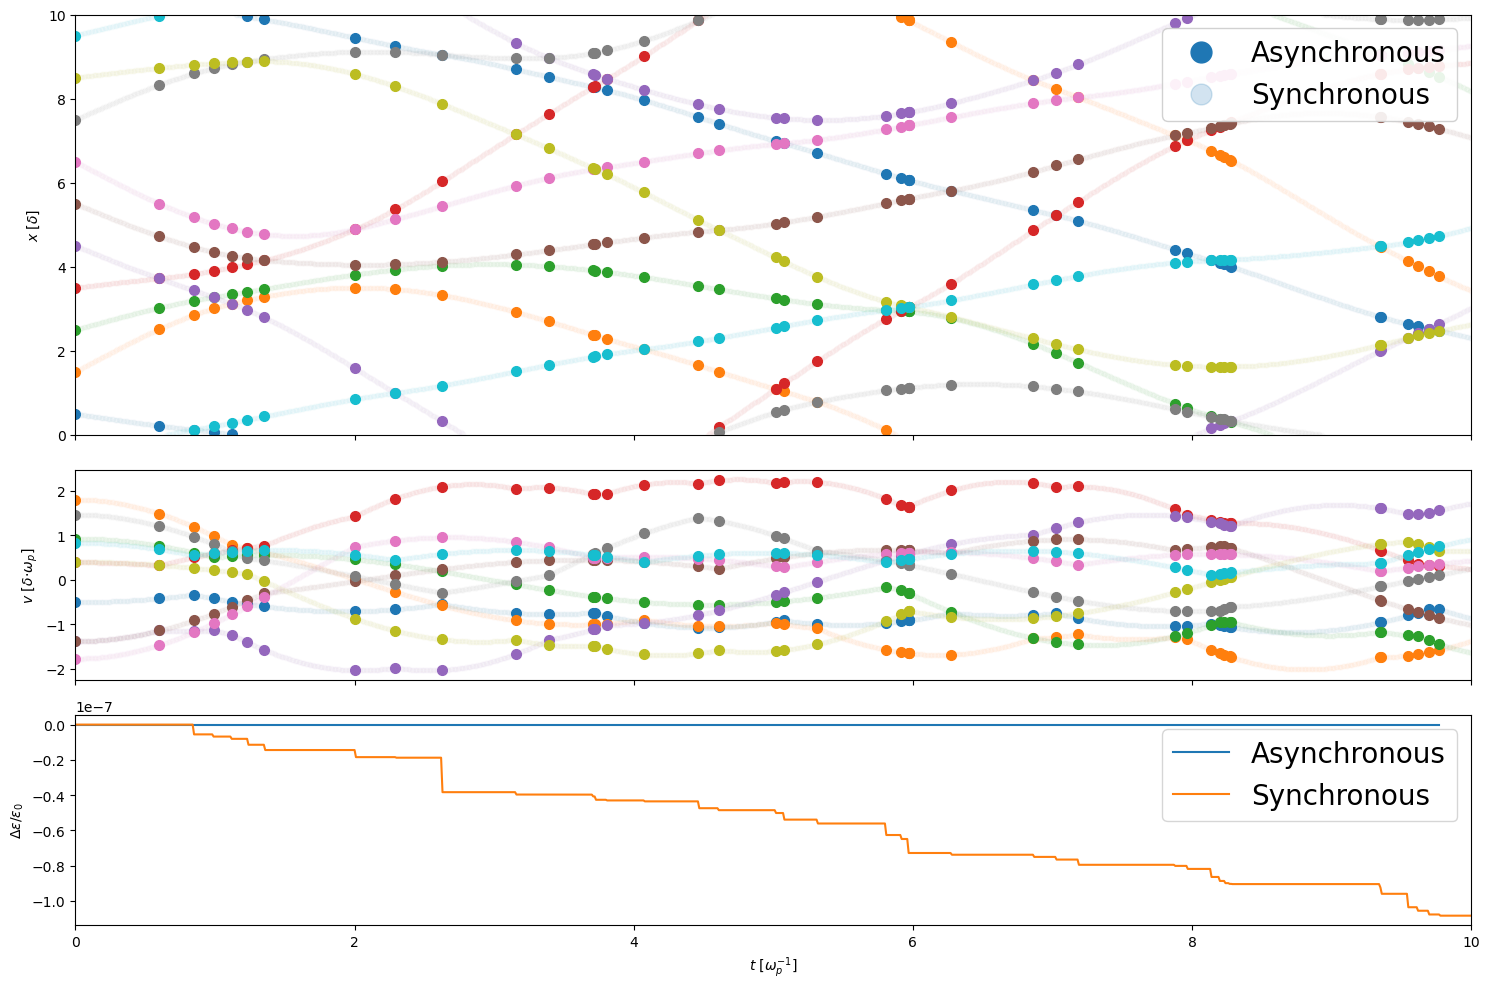

In [15]:
fig, ax = plt.subplots(3,1,figsize=(15,10), sharex=True,
                       gridspec_kw={'height_ratios': [2,1,1]})

T = np.arange(X.shape[0]) * dt

ax[0].plot(T, X / dx_eq, '.', alpha=0.02, ms=7, rasterized=True)
ax[0].plot(T_a, X_a / dx_eq, 'o', ms=7, rasterized=True)
ax[0].set_ylabel('$x$ [$\delta$]')
ax[0].set_ylim(0, X.shape[-1])

ax[1].plot(T, V / dx_eq, '.', alpha=0.02, ms=7, rasterized=True)
ax[1].plot(T_a, V_a / dx_eq, 'o', ms=7, rasterized=True)
ax[1].set_ylabel('$v$ [$\delta\!\cdot\!\omega_p$]')

ax[2].plot(T_a, (E_a - E_a[0])/E_a[0], label='Asynchronous')
ax[2].plot(T, (E - E[0])/E[0], label='Synchronous')
ax[2].set_ylabel('$\Delta\epsilon/\epsilon_0$')
ax[2].legend(fontsize=20)

ax[2].set_xlim([T[0], T[-1]])
ax[2].set_xlabel('$t$ [$\omega_p^{-1}$]')


legend_elements = [Line2D([], [], marker='o', ms=15, ls='', color='tab:blue',label='Asynchronous'),
                   Line2D([], [], marker='o', ms=15, ls='', color='tab:blue', alpha=0.2, label='Synchronous')]

ax[0].legend(handles=legend_elements, loc='upper right', framealpha=0.9, fontsize=20)


plt.tight_layout()
plt.savefig('../img/async_vs_sync.pdf')    
plt.show()

## Convert Async Data to Sync

It is also straightforward to convert the asynchronous data to synchronous time series.

One needs only to specify the desired dt, and up to what time to convert the data ($\leq$ t_max).

In [16]:
X_as, V_as, X_eq_as = async2sync(T=T_a,
                                 X=X_a,
                                 V=V_a,
                                 X_eq=X_eq_a,
                                 dt=dt, 
                                 t_max=t_max)

E_as = np.sum(get_E(X_as, V_as, X_eq_as), axis=0)

print(X_as.shape, V_as.shape, X_eq_as.shape, E_as.shape)

(1001, 10) (1001, 10) (1001, 10) (1001,)


This allows us to obtain synchronous time series with smaller energy variations, which can be usefull to traian GNN models. 

However the difference in trajectories ($\Delta x$) is minimal for cases where the synchronous algorithm provides very good energy conservation results. 

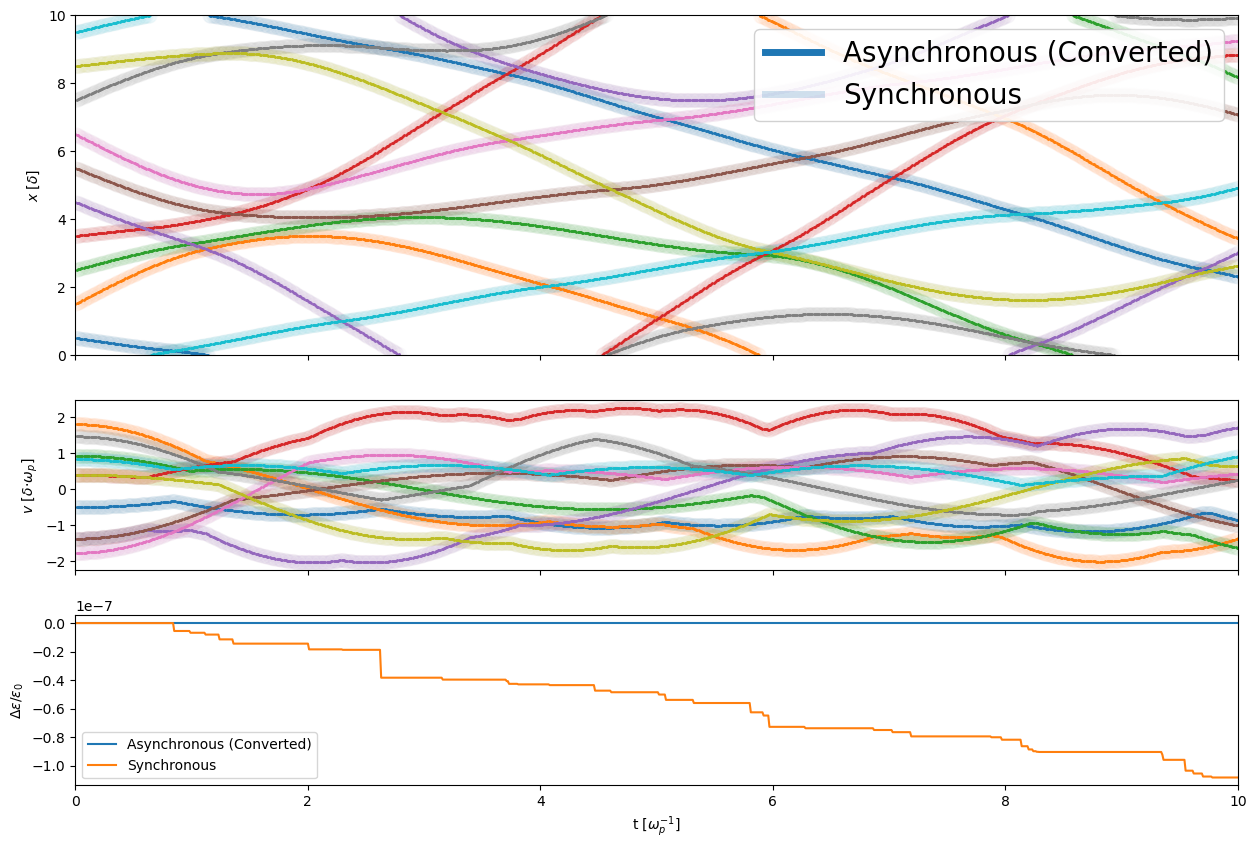

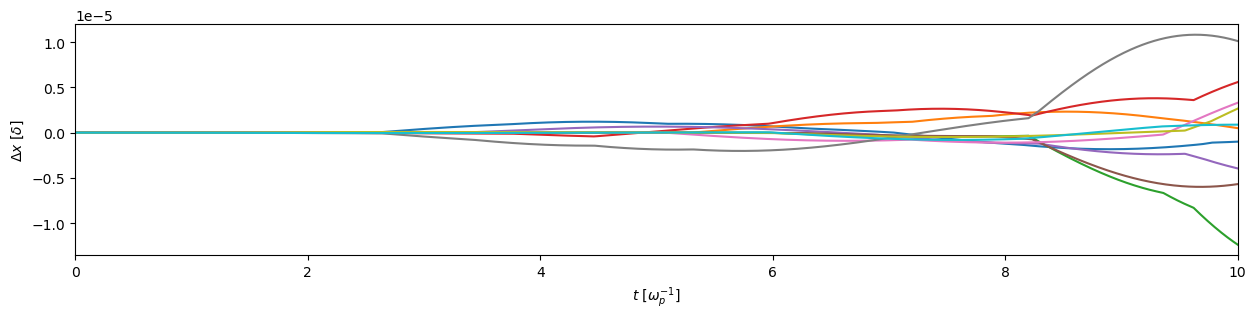

In [17]:
fig, ax = plt.subplots(3,1,figsize=(15,10), sharex=True,
                       gridspec_kw={'height_ratios': [2,1,1]})

T = np.arange(X.shape[0]) * dt

ax[0].plot(T, X / dx_eq, '.', ms=20, alpha=0.02, rasterized=True)
ax[0].plot(T, X_as / dx_eq, 'o', ms=1, rasterized=True)
ax[0].set_ylabel('$x$ [$\delta$]')
ax[0].set_ylim(0, n_sheets)

ax[1].plot(T, V / dx_eq, '.', ms=20, alpha=0.02, rasterized=True)
ax[1].plot(T, V_as / dx_eq, 'o', ms=1, rasterized=True)
ax[1].set_ylabel('$v$ [$\delta\!\cdot\!\omega_p$]')

ax[2].plot(T, (E_as - E_as[0])/E_as[0], label='Asynchronous (Converted)')
ax[2].plot(T, (E - E[0])/E[0], label='Synchronous')
ax[2].set_ylabel('$\Delta\epsilon/\epsilon_0$')
ax[2].legend()

ax[2].set_xlim([T[0], T[-1]])
ax[2].set_xlabel('t [$\omega_p^{-1}$]')

legend_elements = [Line2D([0], [0], color='tab:blue', lw=5,label='Asynchronous (Converted)'),
                   Line2D([0], [0], color='tab:blue', lw=5, alpha=0.2, label='Synchronous')]

ax[0].legend(handles=legend_elements, loc='upper right', framealpha=0.9, fontsize=20)

plt.show()


plt.figure(figsize=(15,3))
for x, xas in zip(X.T, X_as.T):
    plt.plot(T, (x-xas)/ dx_eq)
plt.xlim(T[0], T[-1])
plt.ylabel('$\Delta x$ [$\delta$]')
plt.xlabel('$t$ [$\omega_p^{-1}$]')
plt.show()